In [2]:
import os
os.chdir("../")

from MonteCarlo import MonteCarlo
from Black76 import Black76
import numpy as np
import matplotlib.pyplot as plt

# Option asiatique

## Mini-projet II. Pricing et variable de contôle

Dans cette partie-là on calcule le prix d'option Call asiatique dont le payoff est
$$
\left(\dfrac1T \int_0^TX_t^xdt - K\right)^+
$$
dans le modèle de Black-Scholes.

En tant que variable de contrôle on utilise
$$
\left(x \exp\left\{ \dfrac{1}{2}\left(r - \dfrac{\sigma^2}2T\right) + \dfrac{\sigma}{T}\int_0^TW_tdt\right\} - K\right)^+
$$
dont l'espérance actualisée est prix d'un Call avec $\tilde S_0 = x \exp\left\{-\left(\dfrac{r}2 + \dfrac{\sigma^2}{12}\right)T\right\}$ et $\tilde \sigma = \dfrac{\sigma}{\sqrt{3}}$.

On utilise aussi la méthode adoptative pour la variable de contrôle.

Enfin, nous montrons numériquement que le prix d'option asiatique est plus petit que l'un d'option européenne.

#### Simulation
Afin de faire la simulation avec la variable de contrôle il faut savoir simuler conjointement
$$
\left(W_{t_1}, \ldots, W_{t_n}, \int_0^TW_tdt\right).
$$
On va simuler la trajectoire $W^n$ sur la grille $t_1 < \ldots < t_{k^*} \leq T < t_{k^*+1} < \ldots < t_n$ et ensuite simuler $\int_0^TW_tdt$ de la loi gaussienne conditionnelle.

Car
$$
\int_0^TW_tdt = \sum_{k=1}^{k^*+1}\beta_k \Delta W_{t_k} + \gamma \varepsilon,
$$
où $\Delta W_{t_k} =  W_{t_k} - W_{t_{k-1}}$ et $\varepsilon \bot W^n, \varepsilon \sim \mathcal{N}(0, 1)$, on peut montrer que
$$
\beta_k = \dfrac{\Delta_k}2 + (T - t_k), \quad k = 1, \ldots, k^*, \quad \beta_{k^*+1} = \dfrac{(T-t_{k^*})^2}{2\delta t_{k^*+1}},
$$
où $\Delta t_k =  t_k - t_{k-1}$, et
$$
\gamma^2 = \dfrac{T}3 - \sum_{k=1}^{k^*+1}\beta_k^2 \Delta t_k.
$$
Alors, $\left[\int_0^TW_tdt \Big| W^n\right] \sim \mathcal{N}\left(\sum_{k=1}^{k^*+1}\beta_k \Delta W_{t_k},\ \dfrac{T}3 - \sum_{k=1}^{k^*+1}\beta_k^2 \Delta t_k\right)$.

In [3]:
T = 2
t_grid_size = 50
t_grid = np.linspace(0, T, t_grid_size)

r = 0.05
sigma = 0.2
model = Black76(sigma, r)

n_sample = 10**6
rng = np.random.default_rng(seed=42)
K = 100
S0 = K * np.exp(-r * T)

In [4]:
def simulate_asian_call_option(
    n_sample: int,
    T: float,
    K: float,
    S0: float,
    model: Black76,
    rng: np.random.Generator,
):
    """
    Simulates jointly the integral of the stock price and control variates for call option.
    """
    S_trajs, diffusion = model.simulate_trajectory(
        size=n_sample,
        t_grid=t_grid,
        init_val=S0,
        flag="spot",
        rng=rng,
        return_diffusion=True
    )
    integrals = diffusion.integral_of_brownian_motion(T, squeeze=True)
    price_integral = np.sum(S_trajs[:, :-1] * np.diff(t_grid), axis=1)

    F0_cv = S0 * np.exp((0.5 * model.r - model.sigma**2 / 12) * T)
    model_cv = Black76(sigma=model.sigma / np.sqrt(3), r=model.r)
    mean_cv = model_cv.vanilla_price(T, K, F0_cv, 'c')
    S_T_cv = S0 * np.exp(0.5 * (model.r - 0.5 * model.sigma**2) * T + model.sigma / T * integrals)
    cv = np.exp(-model.r * T) * np.maximum(S_T_cv - K, 0) - mean_cv

    return price_integral, cv


def asian_option_convergence(
    n_sample: int,
    T: float,
    K: float,
    S0: float,
    model: Black76,
    rng: np.random.Generator,        
    ax: plt.axis
):
    price_integral, cv = simulate_asian_call_option(
        n_sample=n_sample,
        T=T,
        K=K,
        S0=S0,
        model=model,
        rng=rng
    )
    sample = np.exp(-r * T) * np.maximum(price_integral / T - K, 0)
    mc = MonteCarlo(sample=sample, confidence_level=0.95)
    mc_cv = MonteCarlo(sample=sample - cv, confidence_level=0.95)
    mc_cv_adapt = MonteCarlo(sample=sample, confidence_level=0.95, control_variate=cv)

    print('Monte Carlo price:', mc.results(6))
    print('MC with control variate:', mc_cv.results(6))
    print('MC with adapted c.v. weights:', mc_cv_adapt.results(6))
    print('Vanilla call price:', model.vanilla_price(T, K, S0*np.exp(r*T), 'c'))

    mc.convergence_diagram(step=1000, ax=ax, log=True, color='b', label='Crude MC', plot_intervals=True)
    mc_cv.convergence_diagram(step=1000, ax=ax, log=True, color='g', label='Control variate', plot_intervals=True)
    mc_cv_adapt.convergence_diagram(step=1000, ax=ax, log=True, color='r', label='Adapted weights', plot_intervals=True)
    ax.set_title('Convergence diagrams for asian option')

Monte Carlo price: 3.797853 ± 0.01519
MC with control variate: 3.793336 ± 0.001054
MC with adapted c.v. weights: 3.793093 ± 0.000706
Vanilla call price: 10.176065455477985


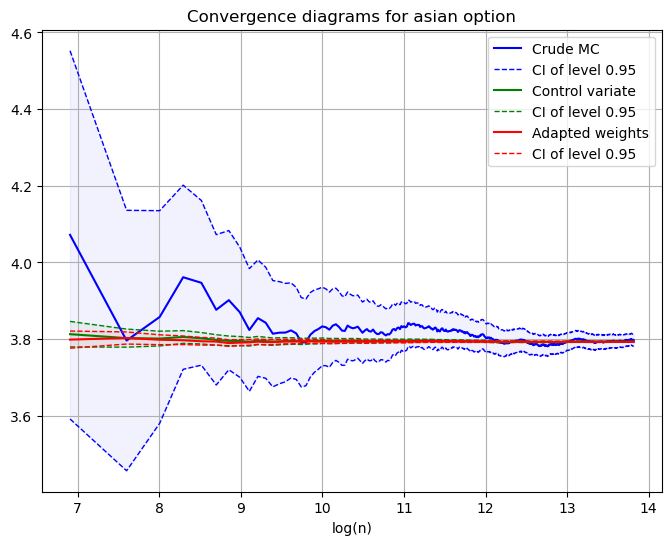

In [5]:
rng = np.random.default_rng(seed=42)
fig, ax = plt.subplots(figsize=(8, 6))

asian_option_convergence(
    n_sample=n_sample,
    T=T,
    K=K,
    S0=S0,
    model=model,
    rng=rng,
    ax=ax
)

vanilla_call_price = model.vanilla_price(T, K, S0*np.exp(r*T), 'c')

## Mini-projet III. Relation Call-Put et la variance pour les strikes différents

### Relation Call-Put asiatique

Comme pour les options vanilles, on note que la différence entre les payoffs de Call et Put asiatiques:
$$
\left(\dfrac1T\int_0^T S_t dt - K \right)^+ - \left(K - \dfrac1T\int_0^T S_t dt\right)^+ = \int_0^T S_t dt - K
$$
En actualisant et prenant l'espérance on obtient
$$
\mathrm{Call}_0^{Asian}(T, K) - \mathrm{Put}_0^{Asian}(T, K) = \dfrac1T\int_0^T e^{-r(T-t)}\underbrace{\mathbb{E}[e^{-rt}S_t]}_{S_0} dt - e^{-rT}K = S_0 \dfrac{1 - e^{-rT}}{rT} - e^{-rT}K.
$$

#### Simulation

Donc on va comparer trois estimateurs Monte Carlo:

1. Call régulier:
$
e^{-rT}\left(\dfrac{1}{m}\sum_{i=0}^{m-1} S_{t_i} - K\right)^+
$
2. Call synthétique:
$
 S_0 \dfrac{1 - e^{-rT}}{rT} - e^{-rT}K + e^{-rT}\left(K - \dfrac{1}{m}\sum_{i=0}^{m-1} S_{t_i} \right)^+
$
3. Call avec variable de contrôle dynamique:
$
X_k = e^{-rT}\left(\dfrac{1}{m}\sum_{i=0}^{m-1} S_{t_i} - K\right)^+ - \lambda_{-k} \left[e^{-rT}\left(S_0 \exp\left\{ \dfrac{1}{2}\left(r - \dfrac{\sigma^2}2T\right) + \dfrac{\sigma}{T}\int_0^TW_tdt\right\} - K\right)^+ - \mathrm{Call^{BS}}(T, K, \tilde S_0, \tilde \sigma, r)\right]
$

In [6]:
T = 1

t_grid_size = 50
t_grid = np.linspace(0, T, t_grid_size)

r = 0.05
sigma = 0.3
model = Black76(sigma, r)

n_sample = 10**6
rng = np.random.default_rng(seed=42)

S0 = 100
K_grid = np.linspace(90, 120, 30)

price_integral, cv = simulate_asian_call_option(
        n_sample=n_sample,
        T=T,
        K=K_grid[:, None],
        S0=S0,
        model=model,
        rng=rng
    )

call_regular = np.exp(-r * T) * np.maximum(price_integral / T - K_grid[:, None], 0)
call_synthetic = S0 * (1 - np.exp(-r * T)) / r / T - np.exp(-r * T) * K_grid[:, None] + np.exp(-r * T) * np.maximum(K_grid[:, None] - price_integral / T, 0)

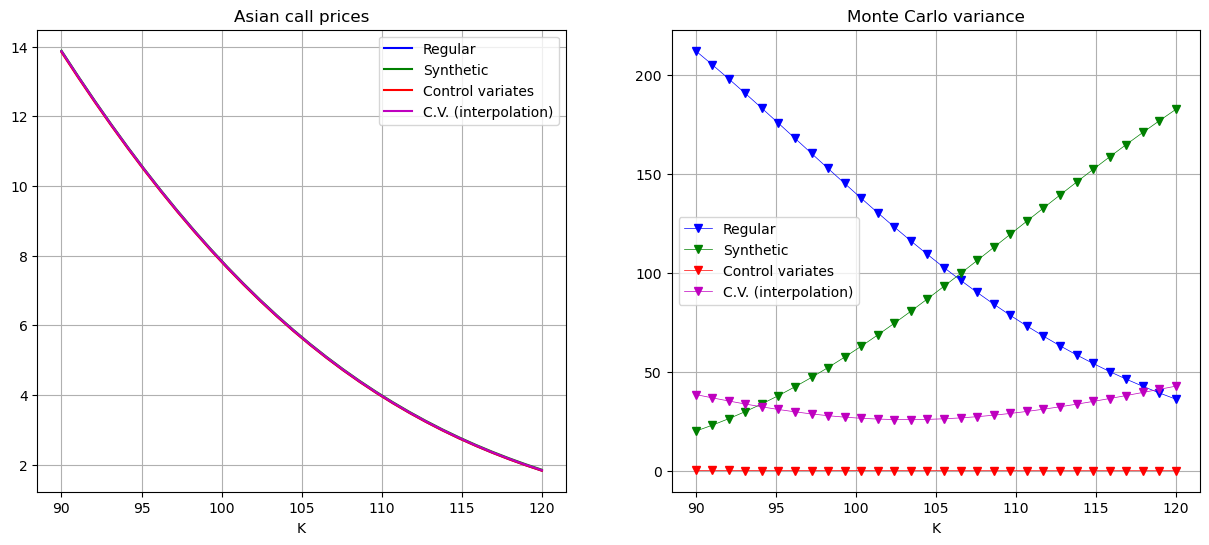

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

mc_regular = MonteCarlo(sample=call_regular, confidence_level=0.95, axis=1)
mc_sythetic = MonteCarlo(sample=call_synthetic, confidence_level=0.95, axis=1)
mc_control = MonteCarlo(sample=call_regular, confidence_level=0.95, control_variate=cv, axis=1)
mc_control_interp = MonteCarlo(sample=call_regular, confidence_level=0.95, control_variate=call_regular - call_synthetic, axis=1)


ax[0].plot(K_grid, mc_regular.mean, color='b', label='Regular')
ax[0].plot(K_grid, mc_sythetic.mean, color='g', label='Synthetic')
ax[0].plot(K_grid, mc_control.mean, color='r', label='Control variates')
ax[0].plot(K_grid, mc_control_interp.mean, color='m', label='C.V. (interpolation)')

ax[0].set_title('Asian call prices')
ax[0].set_xlabel('K')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Monte Carlo variance')
ax[1].set_xlabel('K')
ax[1].plot(K_grid, mc_regular.var, 'bv-', lw=0.5, label='Regular')
ax[1].plot(K_grid, mc_sythetic.var, 'gv-', lw=0.5, label='Synthetic')
ax[1].plot(K_grid, mc_control.var, 'rv-', lw=0.5, label='Control variates')
ax[1].plot(K_grid, mc_control_interp.var, 'mv-', lw=0.5, label='C.V. (interpolation)')

ax[1].grid()
ax[1].legend()

plt.show()